In [32]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))  # Prints your GPU name

True
NVIDIA GeForce RTX 3050


In [ ]:
import os
import pydicom
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Function to load DICOM data and extract metadata
def load_dicom_data(folder_path):
    data = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".dcm"):
                dicom_path = os.path.join(root, file)
                dicom_data = pydicom.dcmread(dicom_path)
                image = dicom_data.pixel_array  # Extract image data
                age_str = dicom_data.PatientBirthDate  # Extract age in 'yyyymmdd' format
                age = convert_age(age_str)  # Convert age to years
                label = assign_label(root)  # Assign label based on folder
                data.append({"Image": image, "Age": age, "Label": label})
    return data

# Function to convert age from 'yyyymmdd' to years
def convert_age(age_str):
    birth_year = int(age_str[:4])
    birth_month = int(age_str[4:6])
    birth_day = int(age_str[6:8])
    # Calculate age (approximate)
    current_year, current_month, current_day = 2023, 10, 1  # Update to current date
    age = current_year - birth_year
    if (current_month, current_day) < (birth_month, birth_day):
        age -= 1
    return age

# Function to assign labels based on folder name
def assign_label(folder_path):
    if "AD" in folder_path:
        return 0  # AD
    elif "MCI" in folder_path:
        return 1  # MCI
    elif "NC" in folder_path:
        return 2  # NC
    else:
        raise ValueError(f"Unknown folder: {folder_path}")

# Load data from all folders
ad_folder = "D:\\Projetos\\AlzheimerEarlyDetection_v2\\MRI_images\\AD"
mci_folder = "D:\\Projetos\\AlzheimerEarlyDetection_v2\\MRI_images\\MCI"
nc_folder = "D:\\Projetos\\AlzheimerEarlyDetection_v2\\MRI_images\\NC"

ad_data = load_dicom_data(ad_folder)
mci_data = load_dicom_data(mci_folder)
nc_data = load_dicom_data(nc_folder)

# Combine all data
data = ad_data + mci_data + nc_data

print(f"Total samples in dataset: {len(data)}")

Total samples in dataset: 474


In [34]:
def extract_metadata(dicom_data):
    metadata = {
        "PatientBirthDate": dicom_data.PatientBirthDate,
        "PatientID": dicom_data.PatientID,
        "Image": dicom_data.pixel_array  # Extract the image data
    }
    return metadata

In [35]:
def convert_age(age_str):
    birth_year = int(age_str[:4])
    birth_month = int(age_str[4:6])
    birth_day = int(age_str[6:8])
    # Calculate age (approximate)
    current_year, current_month, current_day = 2023, 10, 1  # Update to current date
    age = current_year - birth_year
    if (current_month, current_day) < (birth_month, birth_day):
        age -= 1
    return age

In [36]:
import torch, numpy as np

def normalize_uint16_to_float32(image):
    # Verifica se é um tensor do PyTorch
    if isinstance(image, torch.Tensor):
        image = image.to(torch.float32) / 65535.0
    else:  # Caso contrário, assume que é um array NumPy
        image = image.astype(np.float32) / 65535.0
    return image


In [37]:
def convert_uint16_to_uint8(image):
    # Scale to [0, 255] range
    image = (image / 256).astype(np.uint8)
    return image

In [38]:
from torch.utils.data import Dataset

class AlzheimerDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]["Image"]
        label = self.data[idx]["Label"]
        age = self.data[idx]["Age"]
        
        # Normalize the image tensor
        image = normalize_uint16_to_float32(image)
        
        if self.transform:
            image = self.transform(image)
        

        return image, label, age

In [39]:
def assign_label(folder_name):
    if "AD" in folder_name:
        return 0
    elif "MCI" in folder_name:
        return 1
    elif "NC" in folder_name:
        return 2

In [40]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL image
    transforms.Resize((256, 256)),  # Resize to a fixed size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize tensor
])

# Create dataset and dataloader
dataset = AlzheimerDataset(data, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Test one batch
for images, labels, ages in dataloader:
    print("Images shape:", images.shape)  # Should be [batch_size, channels, height, width]
    print("Labels:", labels)
    print("Ages:", ages)
    break

Images shape: torch.Size([32, 1, 256, 256])
Labels: tensor([1, 0, 1, 1, 1, 1, 1, 2, 1, 0, 0, 0, 1, 0, 1, 1, 2, 1, 2, 0, 0, 1, 2, 2,
        0, 1, 1, 2, 0, 2, 0, 1])
Ages: tensor([78, 87, 60, 74, 74, 60, 78, 60, 73, 83, 80, 80, 80, 80, 67, 60, 61, 75,
        63, 80, 89, 66, 61, 57, 93, 67, 79, 61, 83, 63, 96, 67])


In [41]:
import torch.nn as nn
import torch.nn.functional as F

class AlzheimerDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]["Image"]
        label = self.data[idx]["Label"]
        age = self.data[idx]["Age"]

        # Convert uint16 to float32 or uint8
        image = normalize_uint16_to_float32(image)  # Use Option 1 or Option 2

        if self.transform:
            image = self.transform(image)

        return image, label, age

In [42]:
import torch.nn as nn
import torch.nn.functional as F

class AlzheimerCNN(nn.Module):
    def __init__(self):
        super(AlzheimerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 64 * 64, 128)  # Adjust based on image size
        self.fc2 = nn.Linear(128, 3)  # 3 classes: AD, MCI, NC

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [43]:
from torch.utils.data import DataLoader

dataset = AlzheimerDataset(data, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [44]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = AlzheimerCNN().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# for epoch in range(70):  # Number of epochs
#     for images, labels, _ in dataloader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     print(f"Epoch {epoch+1}, Loss: {loss.item()}")

In [45]:
from torch.utils.data import random_split

# Assuming `dataset` is your full dataset
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize lists to store metrics
learning_rates = []
train_accuracies = []
val_accuracies = []

# Define your model, loss function, and optimizer
model = AlzheimerCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(30):  # Number of epochs
    model.train()
    running_loss = 0.0
    y_true = []
    y_pred = []

    for images, labels, _ in dataloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store predictions and true labels
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        running_loss += loss.item()

    # Calculate accuracy
    train_accuracy = accuracy_score(y_true, y_pred)
    train_accuracies.append(train_accuracy)

    # Store learning rate
    learning_rates.append(optimizer.param_groups[0]['lr'])

    # Print metrics
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}, Accuracy: {train_accuracy}, Learning Rate: {optimizer.param_groups[0]['lr']}")

    # Validation (optional)
    model.eval()
    val_true = []
    val_pred = []
    with torch.no_grad():
        for images, labels, _ in val_dataloader:  # Assuming you have a validation DataLoader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(predicted.cpu().numpy())

    val_accuracy = accuracy_score(val_true, val_pred)
    val_accuracies.append(val_accuracy)
    print(f"Validation Accuracy: {val_accuracy}")

Epoch 1, Loss: 6.051462451616923, Accuracy: 0.41561181434599154, Learning Rate: 0.001
Validation Accuracy: 0.47368421052631576
Epoch 2, Loss: 1.0733772317568462, Accuracy: 0.4240506329113924, Learning Rate: 0.001
Validation Accuracy: 0.47368421052631576
Epoch 3, Loss: 1.0239996631940207, Accuracy: 0.4282700421940928, Learning Rate: 0.001
Validation Accuracy: 0.47368421052631576
Epoch 4, Loss: 1.0268725434939066, Accuracy: 0.3860759493670886, Learning Rate: 0.001
Validation Accuracy: 0.35789473684210527
Epoch 5, Loss: 1.0249123771985371, Accuracy: 0.39662447257383965, Learning Rate: 0.001
Validation Accuracy: 0.47368421052631576
Epoch 6, Loss: 1.0264973322550455, Accuracy: 0.43037974683544306, Learning Rate: 0.001
Validation Accuracy: 0.47368421052631576
Epoch 7, Loss: 1.0223925789197286, Accuracy: 0.43037974683544306, Learning Rate: 0.001
Validation Accuracy: 0.47368421052631576
Epoch 8, Loss: 1.0206835627555848, Accuracy: 0.43670886075949367, Learning Rate: 0.001
Validation Accuracy: 

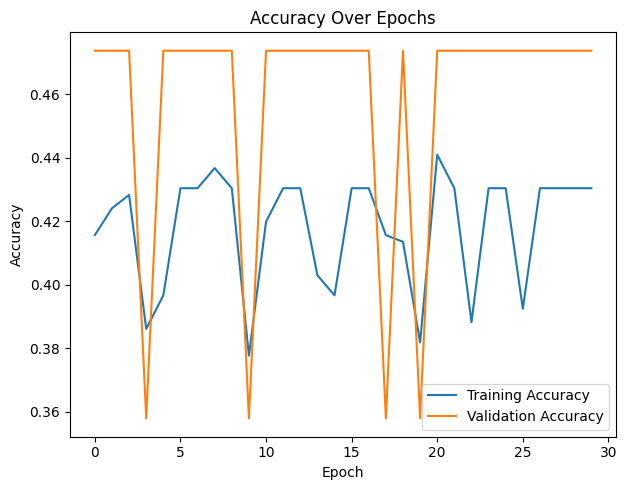

In [49]:
# Plot Learning Rate and Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

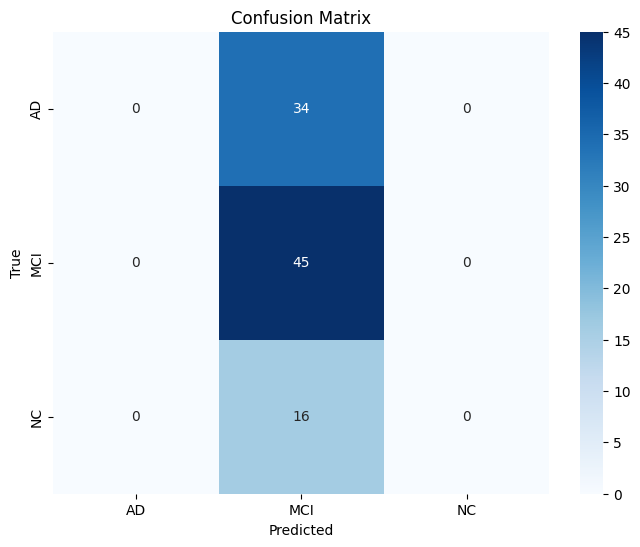

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions for the validation set
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels, _ in val_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["AD", "MCI", "NC"], yticklabels=["AD", "MCI", "NC"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()